In [1]:
import pandas as pd
import numpy as onp

import matplotlib.pyplot as plt
import matplotlib.animation as animation

from IPython.core.display import HTML

In [2]:
# Load in a CSV 
df = pd.read_csv(f'data/alexs_Poisson_SP_test.csv')

In [8]:
# TODO: Move this function to a plotting file or something.
def plot_egress_histogram(df, devices, dt=25, hist_window_seconds=50):
    """
    Returns an animation of the per device histograms of egress times.
    df - DataFrame of packet traces 
    devices - list of device ids
    dt - how many seconds to advance each frame in the animation 
    hist_window_seconds - sliding window size for lookback to generate histograms
    """
    
    fig, axes = plt.subplots(len(devices))
    fig.set_size_inches(8, 3 * len(devices))

    # Get all the packets associated with a given device
    df_ = df.loc[df['cur_hub'].isin(devices)]
    delta_values = (df_['etime'] - df_['timestamp']).values
    bins = onp.linspace(delta_values.min(), delta_values.max() * 0.6 , 50)
    priorities = sorted(pd.unique(df_['priority']))

    # Compute the number of frames to show in our animation
    min_time, max_time = df_['timestamp'].min(), df_['etime'].max()
    n_frames = 1 + int((max_time - min_time - hist_window_seconds) // dt)

    def animate(frame):
        start = frame * dt
        end = frame * dt + hist_window_seconds
        legend = False
        for ax, device in zip(axes, devices):
            ax.clear()
            # Select all entries where egress happened between start and end
            sub_df = df_.loc[(df_['cur_hub'] == device) & (df_['etime'] <= end) & (df_['etime'] >= start)]
            for w in priorities:
                priority_df = sub_df.loc[sub_df['priority'] == w]
                delta_times = (priority_df['etime'] - priority_df['timestamp']).values
                ax.hist(delta_times, bins=bins, label=f'{w}', alpha=(1/len(priorities)) ** 0.5)
            ax.set_ylabel(f"Switch #{device} traffic")
            if not legend:
                ax.legend(title="Priority")
                legend = True
        plt.suptitle(f'Packet Egress times between {start} and {end}')

    anim = animation.FuncAnimation(fig, animate, frames=n_frames)
    return anim
   

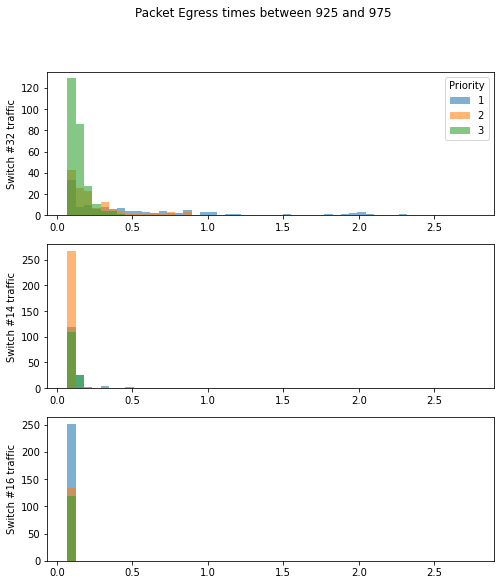

In [9]:
# Get devices to plot the histograms for
devices = pd.unique(df['cur_hub'])[0:15:5]
# Create the animation
anim = plot_egress_histogram(df, devices)
# Plot to jupyter notebook
HTML(animation.Animation.to_jshtml(anim, fps=4))
# Alternatively can save to gif
# anim.save('rsim.gif')